# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.709240711999996
GPU (s):
0.19964458399999785
GPU speedup over CPU: 18x


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import os
import cv2


In [3]:
PUTANJA="/content/drive/My Drive/LDSM projekat/DATA_SET/TRAIN"
PUTANJA_TEST="/content/drive/My Drive/LDSM projekat/DATA_SET/TEST"
CATEGORIES=["LOSI","DOBRI"]

In [4]:
#slike cemo iseci da budu dimenzija 1000x1000
IMAGE_SIZE=300
#trening skup cemo  formirati tako sto cemo slike ucitavati u obliku lista, da bi na kraju prebacili
#trening skup u numpy array objekat
trainingData=[]
testData=[]

In [7]:
import tensorflow as tf
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras.preprocessing.image import random_zoom

In [26]:
#pomocu spajanja stringova dobijam zeljenje putanje i citam podatke(train i test)
for category in CATEGORIES:
    putanja=os.path.join(PUTANJA,category)
    klasa=CATEGORIES.index(category)
    
    for image in os.listdir(putanja):
        #svaku sliku ucitamo u obliku liste, promenimo dimenzije i ubacimo u trening skup
        imageArray=cv2.imread(os.path.join(putanja,image))
        resizedImageArray=cv2.resize(imageArray,(IMAGE_SIZE,IMAGE_SIZE))
        zoom=tf.keras.preprocessing.image.random_zoom(resizedImageArray, zoom_range=(0.3,0.6), row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
        cval=0.0, interpolation_order=1
        )
        #za svaku sliku pamtimo i labelu (klasa)
        trainingData.append([zoom,klasa])
        

for category in CATEGORIES:
    putanja=os.path.join(PUTANJA_TEST,category)
    klasa=CATEGORIES.index(category)
    
    for image in os.listdir(putanja):
        #svaku sliku ucitamo u obliku liste, promenimo dimenzije i ubacimo u trening skup
        imageArray=cv2.imread(os.path.join(putanja,image))
        resizedImageArray=cv2.resize(imageArray,(IMAGE_SIZE,IMAGE_SIZE))
        zoom=tf.keras.preprocessing.image.random_zoom(resizedImageArray, zoom_range=(0.3,0.6), row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
        cval=0.0, interpolation_order=1
        )
        #za svaku sliku pamtimo i labelu (klasa)
        testData.append([zoom,klasa])

In [27]:
import random
random.shuffle(trainingData)
random.shuffle(testData)

In [28]:

train_X=[]
train_Y=[]
test_X=[]
test_Y=[]

#trainging i test data predstavljaju liste lista, gde je svaka lista unutar liste velicine 2 i sadrzi sliku i labelu
#sledeci deo koda vrsi izdvajanje slika i labela u posebne promenljive
for imgArray, label in trainingData:
    train_X.append(imgArray)
    train_Y.append(label)

for imgArray, label in testData:
    test_X.append(imgArray)
    test_Y.append(label)

In [29]:
#uvodjenje potrebnih biblioteka za kreiranje modela
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten,Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [30]:
import numpy as np

In [31]:
train_X=np.array(train_X).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)
test_X=np.array(test_X).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,3)

#labele prebacujemo u kategoricke
#sta to znaci
# u nasem  primeru imamo dobru i losu klasu
#do sad na mam je 1 predstavljalo dobru, a 0 losu klasu
#sada nam vektor [1 0] predstavlja dobru klasu a vektor [0 1] predstavlja losu klasu
train_Y = tf.keras.utils.to_categorical(train_Y, num_classes=2)
test_Y=tf.keras.utils.to_categorical(test_Y, num_classes=2)

In [32]:
model=Sequential()
model.add(Conv2D(64,(3,3),input_shape=train_X.shape[1:],activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))
model.add(Activation('sigmoid'))
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=["accuracy"])

In [33]:
import matplotlib.pyplot as plt

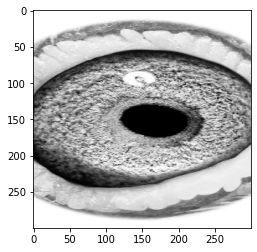

In [34]:
plt.imshow(test_X[1])

In [35]:
model.fit(train_X,train_Y,validation_split=0.3,epochs=5)

Epoch 1/5
3/3 [==============================] - 1s 322ms/step - loss: 5.3003 - accuracy: 0.5823 - val_loss: 5.0657 - val_accuracy: 0.6857
Epoch 2/5
3/3 [==============================] - 1s 181ms/step - loss: 5.7127 - accuracy: 0.6456 - val_loss: 5.0657 - val_accuracy: 0.6857
Epoch 3/5
3/3 [==============================] - 1s 182ms/step - loss: 5.7127 - accuracy: 0.6456 - val_loss: 5.0657 - val_accuracy: 0.6857
Epoch 4/5
3/3 [==============================] - 1s 179ms/step - loss: 5.7127 - accuracy: 0.6456 - val_loss: 5.0657 - val_accuracy: 0.6857
Epoch 5/5
3/3 [==============================] - 1s 180ms/step - loss: 5.7127 - accuracy: 0.6456 - val_loss: 5.0657 - val_accuracy: 0.6857


In [36]:
score = model.evaluate(test_X, test_Y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 6.044286251068115 / Test accuracy: 0.625


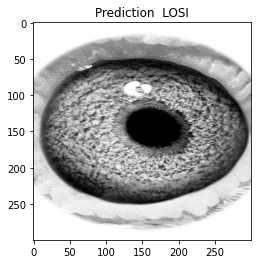

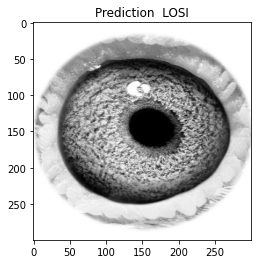

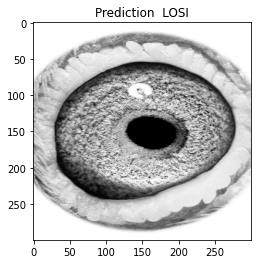

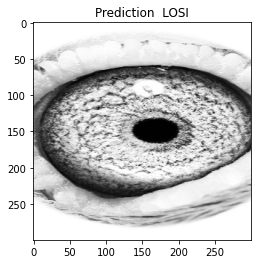

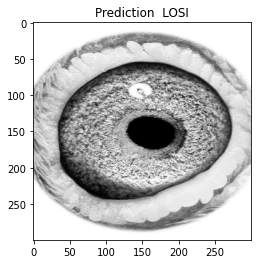

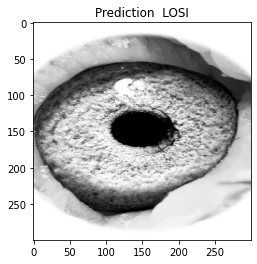

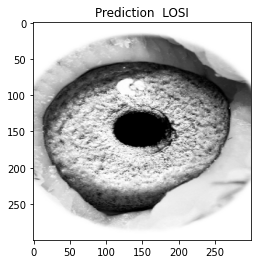

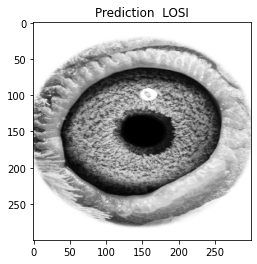

In [122]:
prediction = model.predict(test_X)
for i in range (8):
    plt.grid(False)
    plt.imshow(test_X[i], cmap=plt.cm.binary)
    plt.title("Prediction" + "  " + CATEGORIES[np.argmax(prediction[i])])
    plt.show()

In [37]:
model1 = Sequential()
model1.add(Conv2D(64,(3,3),input_shape=train_X.shape[1:],activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization(axis=2))
model1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization(axis=2))
model1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization(axis=2))
model1.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization(axis=2))
model1.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization(axis=2))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(2, activation = 'softmax'))

model1.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=["accuracy"])

In [38]:
model1.fit(train_X,train_Y,validation_split=0.2,epochs=30)

Epoch 1/30
3/3 [==============================] - 3s 1s/step - loss: 1.4763 - accuracy: 0.6264 - val_loss: 28.1364 - val_accuracy: 0.6522
Epoch 2/30
3/3 [==============================] - 1s 243ms/step - loss: 2.4477 - accuracy: 0.5165 - val_loss: 27.1583 - val_accuracy: 0.6522
Epoch 3/30
3/3 [==============================] - 1s 244ms/step - loss: 0.8172 - accuracy: 0.6593 - val_loss: 0.6739 - val_accuracy: 0.7391
Epoch 4/30
3/3 [==============================] - 1s 243ms/step - loss: 0.6879 - accuracy: 0.6154 - val_loss: 7.4572 - val_accuracy: 0.6522
Epoch 5/30
3/3 [==============================] - 1s 245ms/step - loss: 0.6437 - accuracy: 0.6813 - val_loss: 22.9467 - val_accuracy: 0.6522
Epoch 6/30
3/3 [==============================] - 1s 242ms/step - loss: 0.6614 - accuracy: 0.6593 - val_loss: 8.5856 - val_accuracy: 0.6522
Epoch 7/30
3/3 [==============================] - 1s 246ms/step - loss: 0.6533 - accuracy: 0.6703 - val_loss: 5.0353 - val_accuracy: 0.6522
Epoch 8/30
3/3 [====

In [39]:
score = model1.evaluate(test_X, test_Y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]*100}')

Test loss: 0.7692072987556458 / Test accuracy: 62.5


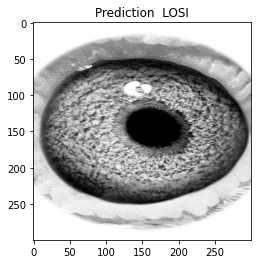

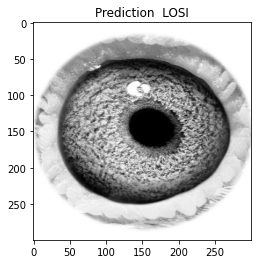

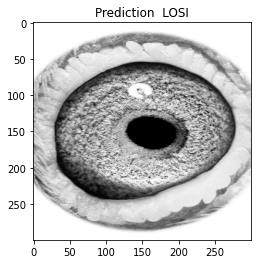

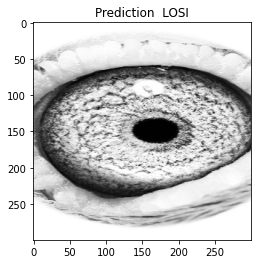

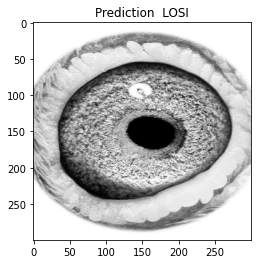

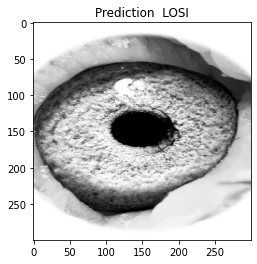

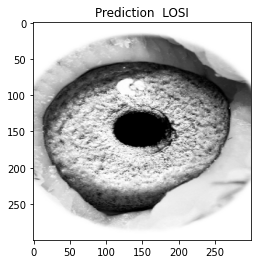

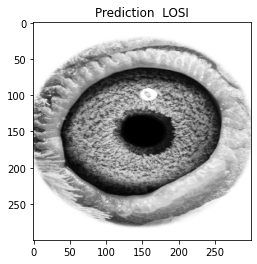

<Figure size 432x288 with 0 Axes>

In [126]:
prediction = model1.predict(test_X)
for i in range (8):
    plt.grid(False)
    plt.imshow(test_X[i], cmap=plt.cm.binary)
    plt.title("Prediction" + "  " + CATEGORIES[np.argmax(prediction[i])])
    plt.show()
    plt.savefig('GoodBad.jpg')

In [40]:
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=train_X.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

In [41]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model2.fit(train_X, train_Y, validation_split=0.2,epochs=20, batch_size=10)

Epoch 1/20
10/10 [==============================] - 1s 109ms/step - loss: 18.5866 - accuracy: 0.5055 - val_loss: 0.6810 - val_accuracy: 0.6957
Epoch 2/20
10/10 [==============================] - 1s 59ms/step - loss: 0.6904 - accuracy: 0.6374 - val_loss: 0.6924 - val_accuracy: 0.5652
Epoch 3/20
10/10 [==============================] - 1s 59ms/step - loss: 0.6509 - accuracy: 0.6593 - val_loss: 0.6438 - val_accuracy: 0.6522
Epoch 4/20
10/10 [==============================] - 1s 59ms/step - loss: 0.6141 - accuracy: 0.6593 - val_loss: 0.6684 - val_accuracy: 0.6522
Epoch 5/20
10/10 [==============================] - 1s 59ms/step - loss: 0.5739 - accuracy: 0.6813 - val_loss: 0.5947 - val_accuracy: 0.6957
Epoch 6/20
10/10 [==============================] - 1s 59ms/step - loss: 0.4775 - accuracy: 0.8022 - val_loss: 0.4926 - val_accuracy: 0.7826
Epoch 7/20
10/10 [==============================] - 1s 60ms/step - loss: 0.4306 - accuracy: 0.8242 - val_loss: 0.4325 - val_accuracy: 0.7826
Epoch 8/20


In [43]:
score = model2.evaluate(test_X, test_Y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]*100}')

Test loss: 0.22155733406543732 / Test accuracy: 87.5


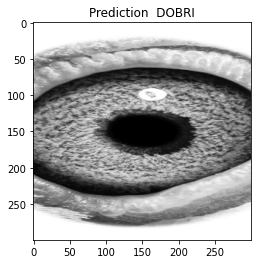

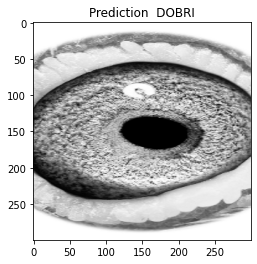

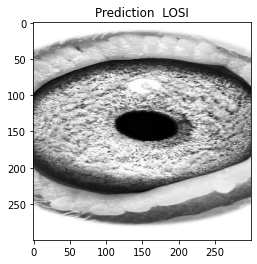

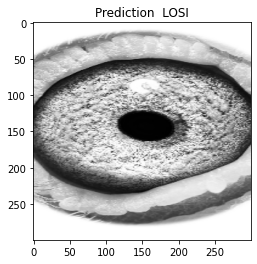

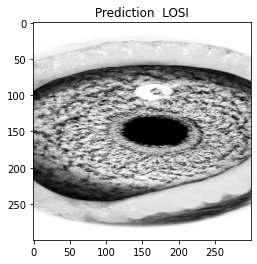

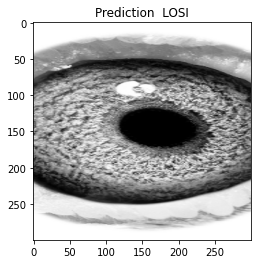

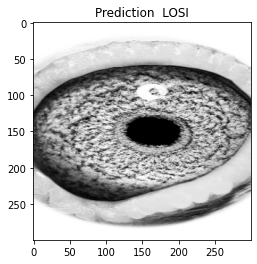

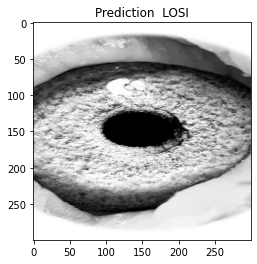

In [44]:
prediction = model2.predict(test_X)
for i in range (8):
    plt.grid(False)
    plt.imshow(test_X[i], cmap=plt.cm.binary)
    plt.title("Prediction" + "  " + CATEGORIES[np.argmax(prediction[i])])
    plt.show()

In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [46]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=train_X.shape[1:])
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [47]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
modelrn50 = Sequential()
modelrn50.add(restnet)
modelrn50.add(Dense(512, activation='relu', input_dim=train_X.shape[1:]))
modelrn50.add(Dropout(0.3))
modelrn50.add(Dense(512, activation='relu'))
modelrn50.add(Dropout(0.3))
modelrn50.add(Dense(256, activation='relu'))
modelrn50.add(Dropout(0.3))
modelrn50.add(Dense(64, activation='relu'))
modelrn50.add(Dropout(0.3))
modelrn50.add(Dense(32, activation='relu'))
modelrn50.add(Dropout(0.3))
modelrn50.add(Dense(2, activation='sigmoid'))
modelrn50.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.01),
              metrics=['accuracy'])
modelrn50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [50]:
modelrn50.fit(train_X,train_Y,validation_split=0.2,epochs=10,batch_size=10)

Train on 91 samples, validate on 23 samples
Epoch 1/10
91/91 [==============================] - 6s 62ms/step - loss: 0.6264 - accuracy: 0.7857 - val_loss: 1.0036 - val_accuracy: 0.6522
Epoch 2/10
91/91 [==============================] - 3s 38ms/step - loss: 3.3638 - accuracy: 0.7033 - val_loss: 0.7217 - val_accuracy: 0.3478
Epoch 3/10
91/91 [==============================] - 3s 38ms/step - loss: 2.0894 - accuracy: 0.7088 - val_loss: 0.9235 - val_accuracy: 0.6522
Epoch 4/10
91/91 [==============================] - 3s 38ms/step - loss: 2.5437 - accuracy: 0.6484 - val_loss: 0.7400 - val_accuracy: 0.3261
Epoch 5/10
91/91 [==============================] - 3s 38ms/step - loss: 2.5009 - accuracy: 0.6538 - val_loss: 0.7252 - val_accuracy: 0.3478
Epoch 6/10
91/91 [==============================] - 3s 38ms/step - loss: 2.5363 - accuracy: 0.6758 - val_loss: 1.8797 - val_accuracy: 0.4348
Epoch 7/10
91/91 [==============================] - 3s 38ms/step - loss: 2.6776 - accuracy: 0.5879 - val_loss:

In [51]:
score = modelrn50.evaluate(test_X, test_Y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5350236892700195 / Test accuracy: 0.625


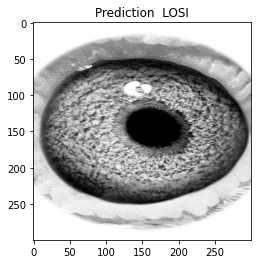

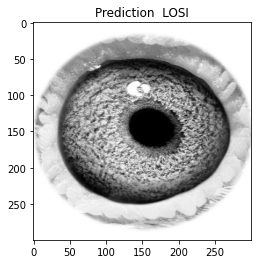

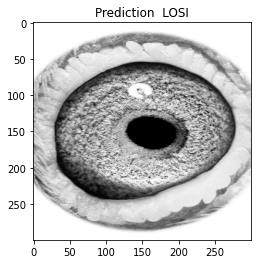

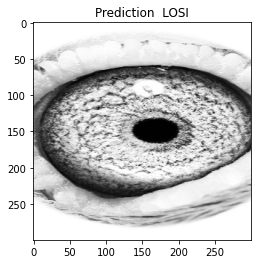

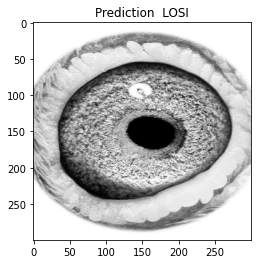

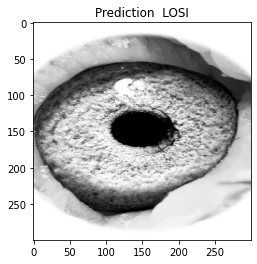

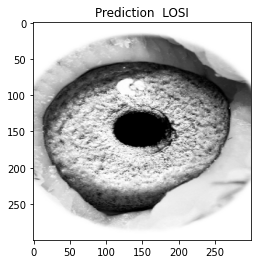

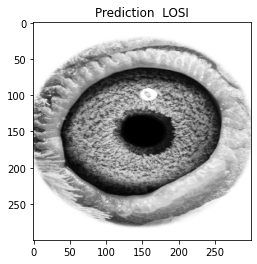

In [137]:
prediction = modelrn50.predict(test_X)
for i in range (8):
    plt.grid(False)
    plt.imshow(test_X[i], cmap=plt.cm.binary)
    plt.title("Prediction" + "  " + CATEGORIES[np.argmax(prediction[i])])
    plt.show()